In [1]:
# Install required packages

!pip install ultralytics -q

!pip install transformers -q

!pip install networkx -q

!pip install kaggle -q

!pip install kagglehub -q

!pip install pyyaml -q

!pip install pyvis -q

!pip install supervision -q

In [2]:
import sys
import os
import json
import matplotlib.pyplot as plt
import networkx as nx

# Add parent directory to path
sys.path.append(os.path.abspath('..'))

from src.graph_builder import build_scene_graph, visualize_polished_static, visualize_graph_html, visualize_planogram_logic
from src.utils import calculate_metrics
from src.config import TARGET_BRANDS

# configuration
RESULTS_DIR = "../results"
GRAPH_DIR = os.path.join(RESULTS_DIR, "graphs")
os.makedirs(GRAPH_DIR, exist_ok=True)

Starting Final Evaluation & Visualization...
Loaded 211 detection records.

Calculating Performance Metrics...

PERFORMANCE METRICS
Total Products Detected: 23000
Successfully Classified: 15606 (67.85%)
Unknown Products:      7394
Average Confidence:    0.8004
Total Relationships:   1591618
------------------------------
Products Detected:
  Coca-Cola: 4732
  Fanta: 4011
  Pepsi: 2435
  Sprite: 2361
  Mountain Dew: 1382
  7 Up: 685


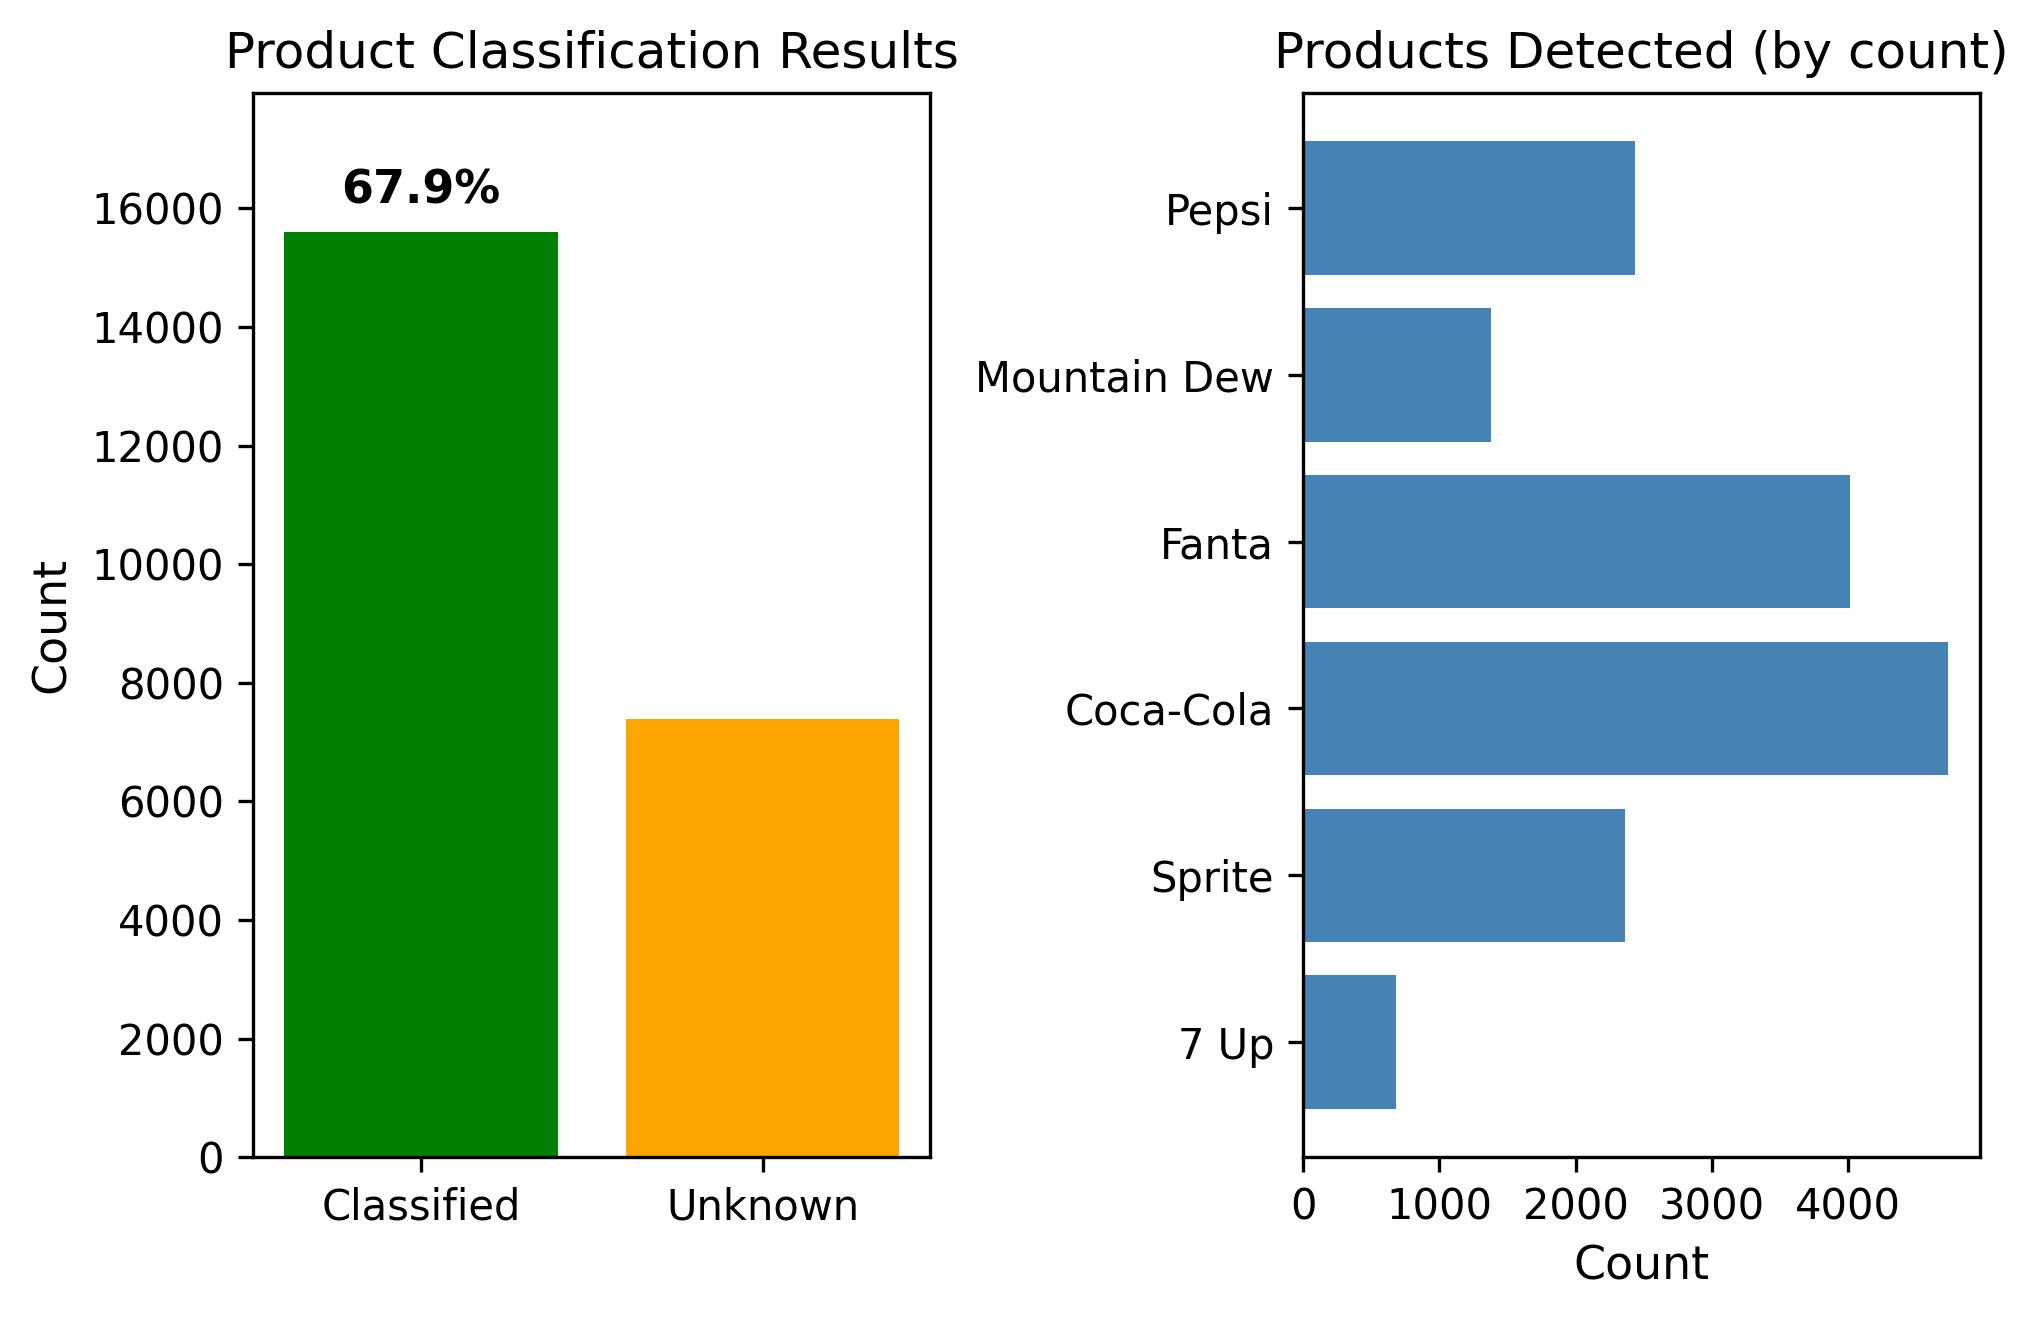

Metrics visualization saved.


In [3]:
print("Starting Final Evaluation & Visualization...")

# load saved data
detections_path = os.path.join(RESULTS_DIR, "all_detections.json")

# load detections
if os.path.exists(detections_path):
    with open(detections_path, 'r') as f:
        all_detections = json.load(f)
    print(f"Loaded {len(all_detections)} detection records.")
else:
    print("Error: 'all_detections.json' not found. Run Pipeline Notebook first.")
    all_detections = []

# --- CALCULATE METRICS ---
if all_detections:
    print("\nCalculating Performance Metrics...")
    metrics = calculate_metrics(all_detections)
    
    # print metrics table
    print("\n" + "="*30)
    print("PERFORMANCE METRICS")
    print("="*30)
    print(f"Total Products Detected: {metrics['total_detections']}")
    print(f"Successfully Classified: {metrics['total_classified']} ({metrics['classification_rate']*100:.2f}%)")
    print(f"Unknown Products:      {metrics['total_unknown']}")
    print(f"Average Confidence:    {metrics['average_confidence']:.4f}")
    print(f"Total Relationships:   {metrics['total_relationships']}")
    print("-" * 30)
    print("Products Detected:")
    for product, count in sorted(metrics['products_detected'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {product}: {count}")
    print("="*30)
    
    # save metrics to file
    with open(os.path.join(RESULTS_DIR, 'final_metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=2)

    # plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(6.8, 4.5), dpi=300)
    
    # Plot 1: Classification Rate
    axes[0].bar(['Classified', 'Unknown'], 
                [metrics['total_classified'], metrics['total_unknown']],
                color=['green', 'orange'])
    axes[0].set_title('Product Classification Results', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=11)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].text(0, metrics['total_classified'] * 1.02,
                 f"{metrics['classification_rate']*100:.1f}%", 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    axes[0].set_ylim(0, max(metrics['total_classified'], metrics['total_unknown']) * 1.15)
    
    # Plot 2: Product Counts
    if metrics['products_detected']:
        products = list(metrics['products_detected'].keys())
        counts = list(metrics['products_detected'].values())
        axes[1].barh(products, counts, color='steelblue')
        axes[1].invert_yaxis() 
        for label in axes[1].get_yticklabels():
            label.set_fontsize(10)
        axes[1].set_title('Products Detected (by count)', fontsize=12)
        axes[1].set_xlabel('Count', fontsize=11)
        axes[1].tick_params(axis='both', labelsize=10)
    
    plt.tight_layout()
    fig.savefig(os.path.join(RESULTS_DIR, 'metrics_visualization.png'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(RESULTS_DIR, 'metrics_visualization.pdf'), bbox_inches='tight')

    plt.show()
    print("Metrics visualization saved.")

In [4]:
import os
import random

def visualize_input_samples(all_detections, input_image_names=None, mode="random"):
    """
    Visualizes the Knowledge Graph for a sample image.
    
    Args:
        all_detections (list): The list of results from the pipeline.
        input_image_names (list): List of specific filenames to look for (e.g. ['test_5.jpg']).
        mode (str): "random" or "selective".
    """
    
    if not all_detections:
        print("No detections data available.")
        return

    print("\nGenerating Knowledge Graph Visualization...")
    sample_data = None

    # MODE A: RANDOM (Pick first valid detection)
    if mode == "random":
        # Shuffle to get a true random sample, or just iterate to find first valid
        # Let's find the first valid one to ensure it works
        candidates = [d for d in all_detections if len(d['boxes']) > 0]
        if candidates:
            sample_data = random.choice(candidates) # Actually pick a random one
        
    # MODE B: SELECTIVE (Pick from user list)
    elif mode == "selective" and input_image_names:
        # Loop through the specific names user requested
        for target_name in input_image_names:
            found = False
            # Find this specific image in the results
            for item in all_detections:
                if item['image'] == target_name and len(item['boxes']) > 0:
                    sample_data = item
                    found = True
                    break
            
            if found:
                # Stop after finding the first match from the list
                break
    
    # --- VISUALIZATION BLOCK ---
    if sample_data:
        print(f"Visualizing graph for image: {sample_data['image']}")
        
        # Rebuild Graph from raw data
        G = build_scene_graph(
            boxes=sample_data['boxes'], 
            labels=sample_data['labels'], 
            confidences=sample_data['confidences'], 
            relationships=sample_data['relationships'], 
            target_brands=TARGET_BRANDS
        )
        
        # Generate files (Appending image name to filename so they don't overwrite)
        base_name = os.path.splitext(sample_data['image'])[0]
        
        star_chart_path = os.path.join(GRAPH_DIR, f"star_chart_{base_name}.html")
        full_graph_path = os.path.join(GRAPH_DIR, f"knowledge_graph_{base_name}.html")
        planogram_path  = os.path.join(GRAPH_DIR, f"planogram_flow_{base_name}.html")
        
        visualize_polished_static(G, output_file=star_chart_path)
        visualize_graph_html(G, output_file=full_graph_path)
        visualize_planogram_logic(G, output_file=planogram_path)
        
        print(f"Graphs generated:\n  - {star_chart_path}\n  - {full_graph_path}\n - {planogram_path}")
    else:
        print("Could not find a valid image with detections matching the input criteria.")

In [5]:
# Option 1: Random
visualize_input_samples(all_detections, mode="random")


Generating Knowledge Graph Visualization...
Visualizing graph for image: 63f08a17-9562-4cc7-99b0-0aa4f1270fd1.jpg
✓ Polished Static Graph saved: ../results/graphs/star_chart_63f08a17-9562-4cc7-99b0-0aa4f1270fd1.html


Full Graph with Legend saved: ../results/graphs/knowledge_graph_63f08a17-9562-4cc7-99b0-0aa4f1270fd1.html


Planogram Flow saved: ../results/graphs/planogram_flow_63f08a17-9562-4cc7-99b0-0aa4f1270fd1.html
Graphs generated:
  - ../results/graphs/star_chart_63f08a17-9562-4cc7-99b0-0aa4f1270fd1.html
  - ../results/graphs/knowledge_graph_63f08a17-9562-4cc7-99b0-0aa4f1270fd1.html
 - ../results/graphs/planogram_flow_63f08a17-9562-4cc7-99b0-0aa4f1270fd1.html


In [6]:
# Option 2: Specific
visualize_input_samples(all_detections, input_image_names=["../data/main-pipeline-testing-datase/24.jpg"], mode="selective")


Generating Knowledge Graph Visualization...
Could not find a valid image with detections matching the input criteria.
